## MTA Turnstile Data Cleaning

In [72]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Read Data from MTA Website

In [73]:
def read_mta(file_nums):
    """
    Function to import data from MTA website
    
    Input: Dates provided in a list of strings, preformatted
    
    Output: Consolidated dataframe
    """
    
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + '.txt')
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list, ignore_index=True)
    df.columns = df.columns.str.strip() #Remove trailing whitespace on column names
    return df


mta = read_mta(['200919', 
                '200912',
                '200905',
                '200801',
                '200808',
                '200815',
                '200822',
                '200829',
                '200725',
                '200718',
                '200711',
                '200704',
                '200627'])

## Exploring the Dataset

In [74]:
mta.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009


In [75]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711632 entries, 0 to 2711631
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 227.6+ MB


In [76]:
mta.describe()

,ENTRIES,EXITS
count,2.711632e+06,2.711632e+06
mean,4.266326e+07,3.497934e+07
std,2.175932e+08,1.982846e+08
min,0.000000e+00,0.000000e+00
25%,2.805560e+05,1.203390e+05
50%,1.786374e+06,1.040209e+06
75%,6.451785e+06,4.307172e+06
max,2.128760e+09,2.123274e+09


Early things to take note of
* Large range in turnstile Entries and Exit Tickers (suggests turnstiles may have started at different times)

## Clean Data
* convert to datetime and sort in ascending order
* Analyze the 'DESC' column & drop rows accordingly
* Difference the entries/exit counts from prior row to get turnstile count for each row
* remove negative entries and exits
* remove total traffic greater than 2400
* convert datetime to day of week int


In [77]:
#convert to datetime and sort
mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta.sort_values(by=['datetime'], inplace=True)

In [78]:
#recovered audits are <1% of total data. Drop!
mta.DESC.value_counts()

REGULAR       2699431
RECOVR AUD      12201
Name: DESC, dtype: int64

In [79]:
#only interested in regular audits. 
mta = pd.DataFrame(mta[mta.DESC == 'REGULAR'])

In [80]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta['n_in'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_out'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [81]:
#adding n_in and n_out to get total turnstile traffic between audits
mta['turn_traffic'] = mta.n_in + mta.n_out

In [82]:
#n_in and n_out have negative quantities
mta.describe()

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,2.699431e+06,2.699431e+06,2.694432e+06,2.694432e+06,2.694432e+06
mean,4.265449e+07,3.496796e+07,-2.380128e+02,4.761911e+02,2.381783e+02
std,2.175794e+08,1.982494e+08,3.602118e+06,2.759846e+06,5.556849e+06
min,0.000000e+00,0.000000e+00,-1.895328e+09,-1.813836e+09,-3.051188e+09
25%,2.799710e+05,1.203770e+05,1.000000e+00,2.000000e+00,4.000000e+00
50%,1.785383e+06,1.039748e+06,1.300000e+01,1.500000e+01,3.700000e+01
75%,6.449905e+06,4.305638e+06,5.000000e+01,4.900000e+01,1.090000e+02
max,2.128760e+09,2.123274e+09,1.879048e+09,1.740393e+09,2.371192e+09


/home/navish/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='turn_traffic', ylabel='Density'>

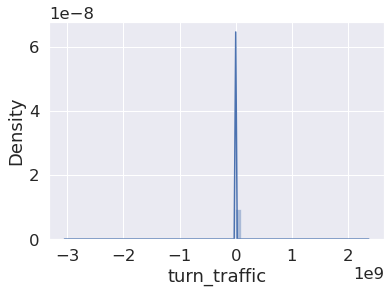

In [83]:
sns.distplot(mta.turn_traffic, kde=True)

In [84]:
len(mta[mta.turn_traffic<0])/len(mta)

0.007945378118573878

Takeaways:
* Large gap in maximum turnstile traffic data ~1 BILLION
* Some Negative Values but they take up less than 1% of the data

Lets drop the negative values and assume that at a maximum, ten people will pass through a turnstile in a minute.  
This caps the four hour traffic at 2400 people passing through a specific turnstile. 

In [85]:
mask = (mta.n_in >= 0) & (mta.n_out >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 2400)
mta = mta[mask]

/home/navish/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='turn_traffic'>

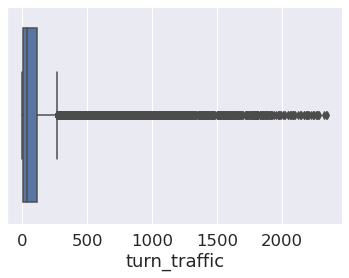

In [86]:
sns.boxplot(mta.turn_traffic)

For later use, break down the further mta data to show their individual weekdays.

In [87]:
mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())

## Analysis

Total Traffic across all turnstiles are aggregated at station level.
Highest ranking stations will be used for further analysis & recommendation.

### Ranking Stations Traffic For entire DataFrame

In [88]:
#Summing up traffic by station
stations_totals = mta.groupby('STATION', as_index=False).turn_traffic.sum()

In [89]:
stations_totals.rename(columns={'turn_traffic':'total_st_traffic'}, inplace=True)

In [90]:
stations_totals.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [91]:
stations_totals[:11]

,STATION,total_st_traffic
61,34 ST-PENN STA,4731445.0
59,34 ST-HERALD SQ,3770944.0
9,125 ST,3723671.0
110,86 ST,3378209.0
14,14 ST-UNION SQ,3233501.0
233,GRD CNTRL-42 ST,3065539.0
68,42 ST-PORT AUTH,3017721.0
46,23 ST,2810212.0
217,FLUSHING-MAIN,2728575.0
226,FULTON ST,2635630.0


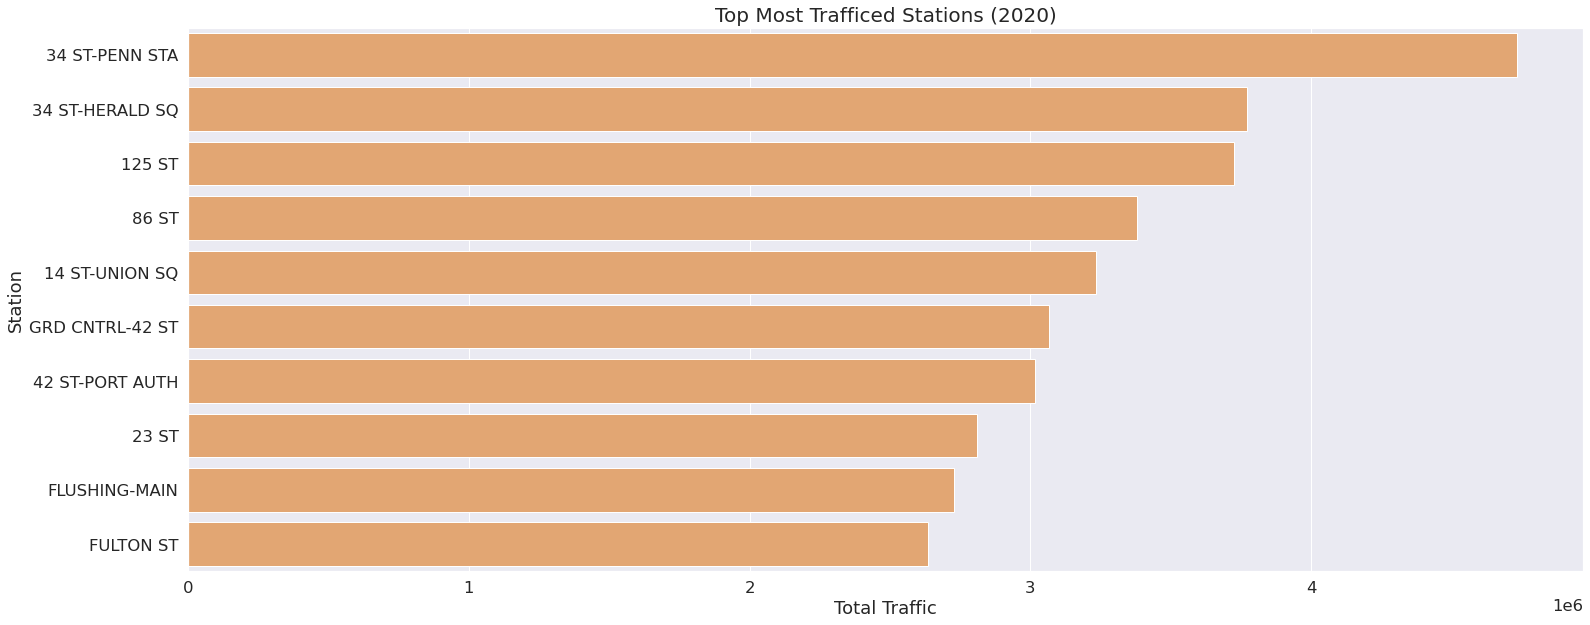

In [92]:
plt.figure(figsize=[25,10])

sns.barplot(x='total_st_traffic', y='STATION', data=stations_totals[:10], color='sandybrown')
plt.title('Top Most Trafficed Stations (2020)', fontsize=20)
plt.xlabel('Total Traffic', fontsize=18)
plt.ylabel('Station', fontsize=18);

### Verifying Top 10 Stations From 2019

In [93]:
#loading in 2019 data
mta19 = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

In [94]:
mta19.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,00:00:00,REGULAR,7206966,2441290
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,04:00:00,REGULAR,7206983,2441292
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,08:00:00,REGULAR,7207003,2441323
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,12:00:00,REGULAR,7207073,2441395
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,16:00:00,REGULAR,7207260,2441450
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,20:00:00,REGULAR,7207572,2441489
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,00:00:00,REGULAR,7207748,2441513
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,04:00:00,REGULAR,7207773,2441521
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,08:00:00,REGULAR,7207784,2441536
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,12:00:00,REGULAR,7207848,2441602


### Cleaning

In [95]:
mta19['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta19 = pd.DataFrame(mta19[mta19.DESC == 'REGULAR'])
mta19.sort_values(by=['datetime'], inplace=True)

#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta19['n_in'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta19['n_out'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

#adding n_in and n_out to get total turnstile traffic between audits
mta19['turn_traffic'] = mta19.n_in + mta19.n_out

mask19 = (mta19.n_in >= 0) & (mta19.n_out >= 0) & (mta19.turn_traffic >= 0) & (mta19.turn_traffic < 2400)
mta19 = mta19[mask19]

In [96]:
mta19['total_st_traffic'] = mta19.groupby('STATION').turn_traffic.transform('sum')

In [97]:
mta19.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,total_st_traffic
1021247,R635,R277,00-00-01,PRESIDENT ST,25,IRT,08/29/2019,16:00:00,REGULAR,5959160,7671664,2020-08-03 00:00:00,267.0,293.0,560.0,431210.0
2377768,N554,R423,01-04-01,AVENUE N,F,IND,07/12/2019,01:00:00,REGULAR,0,395,2020-06-28 09:00:00,0.0,0.0,0.0,306775.0
836154,B020,R263,00-03-00,AVENUE H,BQ,BMT,08/27/2019,00:00:00,REGULAR,10318,9567,2020-08-01 12:00:00,1002.0,916.0,1918.0,694850.0
2508372,G011,R312,00-00-00,W 8 ST-AQUARIUM,FQ,BMT,07/03/2019,08:00:00,REGULAR,4351392,9301818,2020-06-21 12:00:00,5.0,55.0,60.0,472495.0
1465941,D006,R398,01-05-00,NEW UTRECHT AV,ND,BMT,08/07/2019,13:00:00,REGULAR,897,0,2020-08-26 21:00:00,0.0,0.0,0.0,574933.0


### Analysis

In [98]:
stations_totals19 = mta19[['STATION', 'total_st_traffic']]

stations_totals19 = stations_totals19.drop_duplicates()

stations_totals19.sort_values(by='total_st_traffic', ascending=False, inplace=True)

top_ten_stations_totals19 = pd.DataFrame(stations_totals19[:11])
top_ten_stations_totals19

,STATION,total_st_traffic
2615633,34 ST-PENN STA,21062609.0
2640593,GRD CNTRL-42 ST,16824278.0
2577412,34 ST-HERALD SQ,13644047.0
2577916,23 ST,13632836.0
2618653,TIMES SQ-42 ST,12819753.0
2538690,FULTON ST,12715131.0
2634700,14 ST-UNION SQ,12245719.0
2529310,42 ST-PORT AUTH,11705299.0
2526254,86 ST,11128009.0
2524784,125 ST,10363036.0


In [99]:
### Compare to 2020 data

top_ten_stations_totals20 = pd.DataFrame(stations_totals[:11])
top_ten_stations_totals20

,STATION,total_st_traffic
61,34 ST-PENN STA,4731445.0
59,34 ST-HERALD SQ,3770944.0
9,125 ST,3723671.0
110,86 ST,3378209.0
14,14 ST-UNION SQ,3233501.0
233,GRD CNTRL-42 ST,3065539.0
68,42 ST-PORT AUTH,3017721.0
46,23 ST,2810212.0
217,FLUSHING-MAIN,2728575.0
226,FULTON ST,2635630.0


In [100]:
# Adding a column to denote year in each DataFrame, for visualizing purposes

top_ten_stations_totals19['year'] = 2019
top_ten_stations_totals20['year'] = 2020
top_ten_stations_totals19 = top_ten_stations_totals19.reset_index()
top_ten_stations_totals20 = top_ten_stations_totals20.reset_index()

In [101]:
top_ten_stations_totals19

,index,STATION,total_st_traffic,year
0,2615633,34 ST-PENN STA,21062609.0,2019
1,2640593,GRD CNTRL-42 ST,16824278.0,2019
2,2577412,34 ST-HERALD SQ,13644047.0,2019
3,2577916,23 ST,13632836.0,2019
4,2618653,TIMES SQ-42 ST,12819753.0,2019
5,2538690,FULTON ST,12715131.0,2019
6,2634700,14 ST-UNION SQ,12245719.0,2019
7,2529310,42 ST-PORT AUTH,11705299.0,2019
8,2526254,86 ST,11128009.0,2019
9,2524784,125 ST,10363036.0,2019


In [102]:
top_ten_stations_totals20

,index,STATION,total_st_traffic,year
0,61,34 ST-PENN STA,4731445.0,2020
1,59,34 ST-HERALD SQ,3770944.0,2020
2,9,125 ST,3723671.0,2020
3,110,86 ST,3378209.0,2020
4,14,14 ST-UNION SQ,3233501.0,2020
5,233,GRD CNTRL-42 ST,3065539.0,2020
6,68,42 ST-PORT AUTH,3017721.0,2020
7,46,23 ST,2810212.0,2020
8,217,FLUSHING-MAIN,2728575.0,2020
9,226,FULTON ST,2635630.0,2020


In [103]:
# Combining the two dataframes to visualize them easily
# Dropping stations that do not appear in both years 

top_ten_stations_both = pd.concat([top_ten_stations_totals19, top_ten_stations_totals20], ignore_index = True)
to_drop = top_ten_stations_both[top_ten_stations_both['STATION'] == 'FLUSHING-MAIN'].index
to_drop2 = top_ten_stations_both[top_ten_stations_both['STATION'] == '59 ST'].index
to_drop3 = top_ten_stations_both[top_ten_stations_both['STATION'] == '59 ST COLUMBUS'].index
top_ten_stations_both.drop(to_drop, inplace = True)
top_ten_stations_both.drop(to_drop2, inplace = True)
top_ten_stations_both.drop(to_drop3, inplace = True)

# Adding times squre to 2020
times_square = stations_totals[stations_totals['STATION'] == 'TIMES SQ-42 ST']
times_square['year'] = 2020
top_ten_stations_both = pd.concat([top_ten_stations_both, times_square], ignore_index = True)
top_ten_stations_both.dropna(subset = ['year'], inplace = True)
top_ten_stations_both.year.astype('int64')

top_ten_stations_both

<ipython-input-103-89af001af817>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times_square['year'] = 2020


,index,STATION,total_st_traffic,year
0,2615633.0,34 ST-PENN STA,21062609.0,2019
1,2640593.0,GRD CNTRL-42 ST,16824278.0,2019
2,2577412.0,34 ST-HERALD SQ,13644047.0,2019
3,2577916.0,23 ST,13632836.0,2019
4,2618653.0,TIMES SQ-42 ST,12819753.0,2019
5,2538690.0,FULTON ST,12715131.0,2019
6,2634700.0,14 ST-UNION SQ,12245719.0,2019
7,2529310.0,42 ST-PORT AUTH,11705299.0,2019
8,2526254.0,86 ST,11128009.0,2019
9,2524784.0,125 ST,10363036.0,2019


### Ploting the two

<Figure size 1440x720 with 0 Axes>

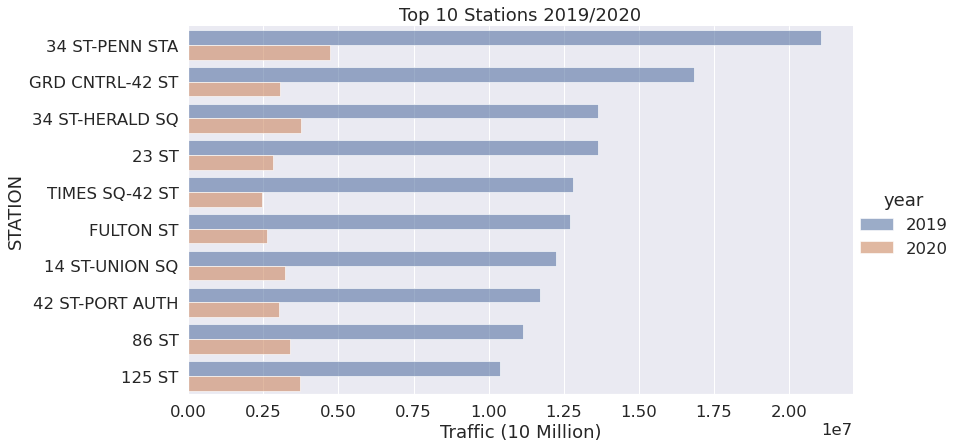

In [104]:
plt.figure(figsize=[20,10])
compare_years = sns.catplot(
    data = top_ten_stations_both, kind = "bar",
    y = "STATION", x ="total_st_traffic", hue = "year", 
    palette = sns.color_palette(), alpha=.6, height=6,
    aspect = 2, 
)

compare_years.set(xlabel = "Traffic (10 Million)")
compare_years.set(title = "Top 10 Stations 2019/2020")
plt.show();

---

## Formulating the Recommendation Around Top Stations

In [105]:
#Assume focus on top ten total traffic
n=10

#increase to top 10
s = [each for _, each in stations_totals[:n]['STATION'].items()]

In [106]:
#Change df name to top_ranking
top_ranked_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [107]:
top_ranked_df.STATION.value_counts()

34 ST-PENN STA     53056
FULTON ST          52126
GRD CNTRL-42 ST    39685
23 ST              39024
86 ST              34359
34 ST-HERALD SQ    28207
42 ST-PORT AUTH    25803
125 ST             22704
14 ST-UNION SQ     22436
FLUSHING-MAIN      14113
Name: STATION, dtype: int64

In [108]:
# Determine Daily Cumulative traffic by day of week from Top n Stations of all time

daily_df = mta[mta.STATION.isin(s[:n])].groupby(['STATION','day_of_week'], as_index=False).turn_traffic.sum()
daily_df.rename(columns={'turn_traffic':'daily_traffic'}, inplace=True)

Text(0.5, 1.0, 'Cumulative Daily Traffic')

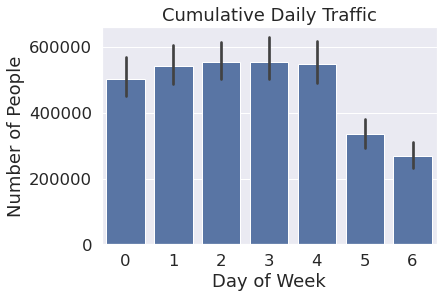

In [109]:
sns.barplot(x='day_of_week', y='daily_traffic', data=daily_df, color='b')

plt.xlabel('Day of Week')
plt.ylabel('Number of People')
plt.title('Cumulative Daily Traffic')

### Ranking Stations filtered for Weekdays

In [110]:
wkday_df = pd.DataFrame(mta[mta.day_of_week < 5])

In [111]:
wkday_rank = wkday_df.groupby(['STATION'], as_index=False).turn_traffic.sum()
wkday_rank.sort_values('turn_traffic', ascending=False, inplace=True)
wkday_rank.head(7)

,STATION,turn_traffic
61,34 ST-PENN STA,3870985.0
59,34 ST-HERALD SQ,3086514.0
9,125 ST,2936132.0
110,86 ST,2780528.0
233,GRD CNTRL-42 ST,2614805.0
14,14 ST-UNION SQ,2582463.0
68,42 ST-PORT AUTH,2452743.0


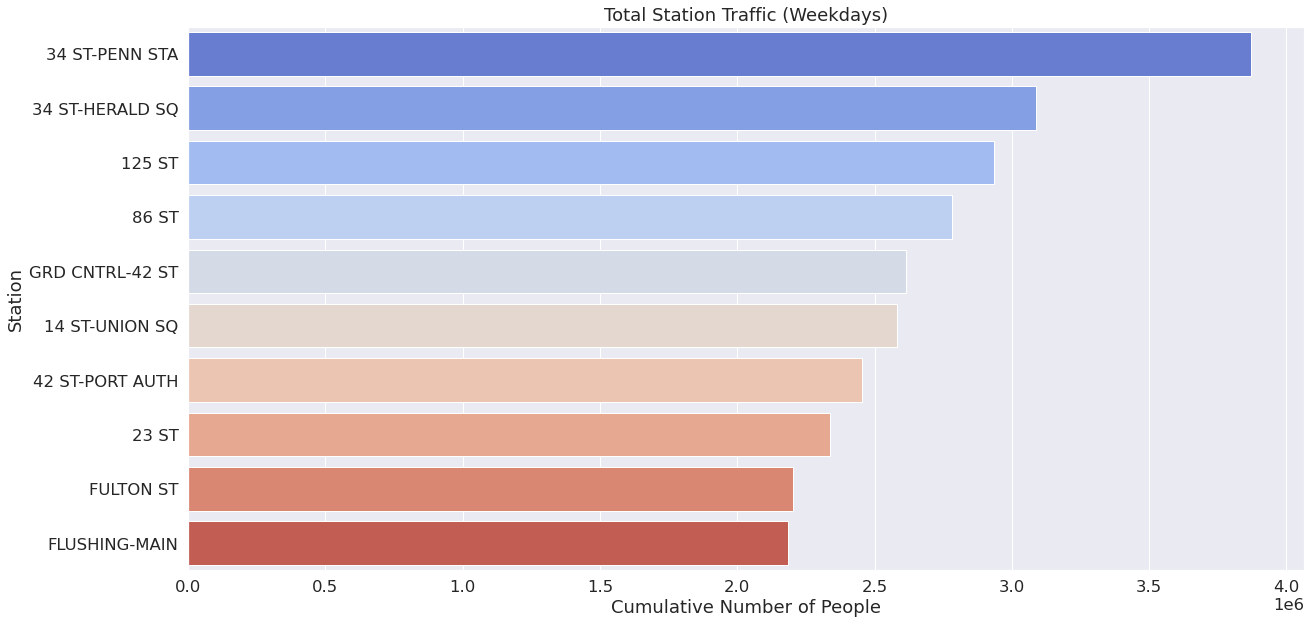

In [112]:
plt.figure(figsize=(20,10))

sns.barplot(x='turn_traffic', y='STATION', data=wkday_rank[:10], palette='coolwarm')
plt.title('Total Station Traffic (Weekdays)')
plt.ylabel('Station')
plt.xlabel('Cumulative Number of People');

### Top Stations Average Traffic by Day 

In [113]:
df = mta[mta.STATION.isin(s)].groupby(['STATION', 'DATE', 'day_of_week'], as_index=False).turn_traffic.sum()
df['mean_d_traffic'] = df.groupby(['STATION','day_of_week']).turn_traffic.transform('mean')
df.drop(columns=['turn_traffic','DATE'], inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,STATION,day_of_week,mean_d_traffic
0,125 ST,5,33085.307692
1,125 ST,6,27494.615385
2,125 ST,0,42731.307692
3,125 ST,1,44498.461538
4,125 ST,2,44809.076923


In [114]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
df.day_of_week = df.day_of_week.map(lambda x : str(x)).map(wkday_dict)

A separate geographical analysis was performed & as part of final recommendation, only lower Manhattan stations are being considered. 
These stations have a high volume of traffic & are located close to each other, allowing for optimization of street teams.

In [115]:
#Filter for Lower Manhatan Stations Only
manhattan_stations = s[0:2]+s[4:9]

Text(0.5, 1.0, 'Average Daily Traffic')

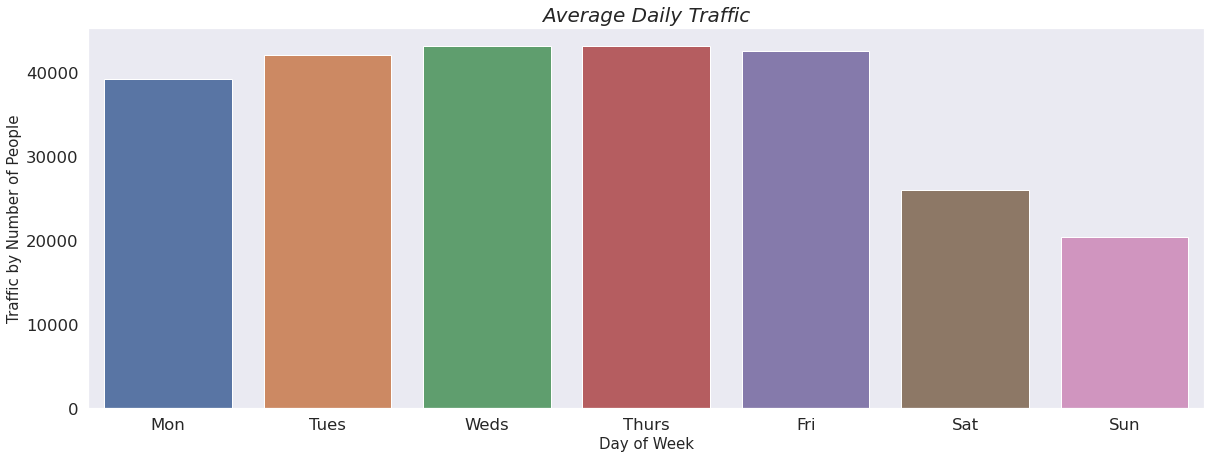

In [116]:
plt.figure(figsize=[20,7])
LIMIT = 9
sns.set_style('dark')
sns.barplot(x='day_of_week', 
            y='mean_d_traffic',  
            data=df[(df.STATION.isin(manhattan_stations))], 
            order=['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],
            ci=None)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Traffic by Number of People', fontsize=15)
plt.title('Average Daily Traffic', fontsize=20, fontstyle='oblique')
#use manhattan stations variable in hue order b/c its the top 5 in order

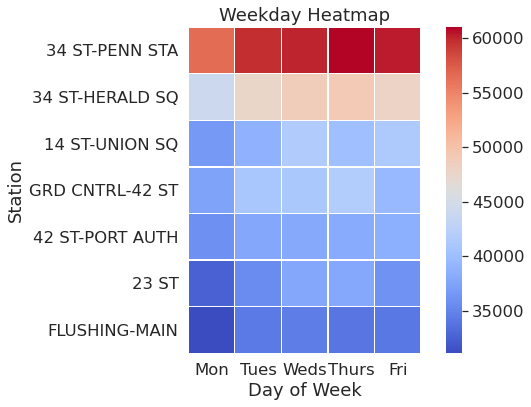

In [117]:
col_order=['Mon','Tues','Weds','Thurs','Fri']
pivot_df2 = df[df.STATION.isin(manhattan_stations)].pivot(index='STATION', columns='day_of_week', values='mean_d_traffic').reindex(col_order, axis=1).reindex(manhattan_stations, axis=0)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_df2, annot=False, linewidths=.5, ax=ax, cmap="coolwarm", square=True)
plt.title('Weekday Heatmap')
plt.xlabel('Day of Week')
plt.ylabel('Station');

### Chunking timeslots into windows

Break time into categories

* **Morning Hours 5:01-13:00** <-- 8 hour workdays
* **Evening Hours 13:01-21:00** <-- 8 hour workdays

Remaining Hours were ignored

In [118]:
mta.TIME.value_counts().head(35)

04:00:00    225080
20:00:00    224688
16:00:00    224594
12:00:00    224456
08:00:00    224393
00:00:00    221690
05:00:00    166921
17:00:00    166534
21:00:00    166411
09:00:00    166363
13:00:00    166349
01:00:00    164688
22:00:00     10009
06:00:00      9963
14:00:00      9951
18:00:00      9945
10:00:00      9927
02:00:00      9841
11:00:00      3548
19:00:00      3547
15:00:00      3546
07:00:00      3544
23:00:00      3542
03:00:00      3503
08:22:00      3191
04:22:00      3156
16:22:00      3151
20:22:00      3120
12:22:00      3117
00:22:00      3103
10:30:00      1821
18:30:00      1820
22:30:00      1811
06:30:00      1802
14:30:00      1800
Name: TIME, dtype: int64

In [119]:
import datetime as dt

def time_cat(x):
    """
    Function to group time periods into morning or evening
    Input: DateTime
    
    Output: Morning, Evening or none
    """
    
    curr = x.time()
    
    if dt.time(5,1) < curr < dt.time(13,1):
        return 'Morning'
    elif dt.time(13,1) < curr < dt.time(20,1):
        return 'Evening'
    else:
        return None

mta['timeblock'] = mta.datetime.apply(time_cat)



In [120]:
# Transforming the original cleaned data frame, to get daily traffic average & total values

time_df = mta.dropna()[['STATION','DATE','turn_traffic','timeblock','day_of_week']]
time_df['st_daily_traff'] = time_df.groupby(['STATION','DATE','timeblock']).turn_traffic.transform('sum')
time_df['mean_daily_traf'] = time_df.groupby(['STATION','day_of_week','timeblock']).st_daily_traff.transform('mean')
time_df.drop_duplicates(inplace=True)

In [121]:
# Housekeeping items - sort & drop extra columns along with filtering out weekends

time_df.sort_values(['timeblock','st_daily_traff'], ascending=False)
time_df.drop(columns=['DATE','st_daily_traff'], inplace=True)
time_df = time_df[time_df.day_of_week<5]

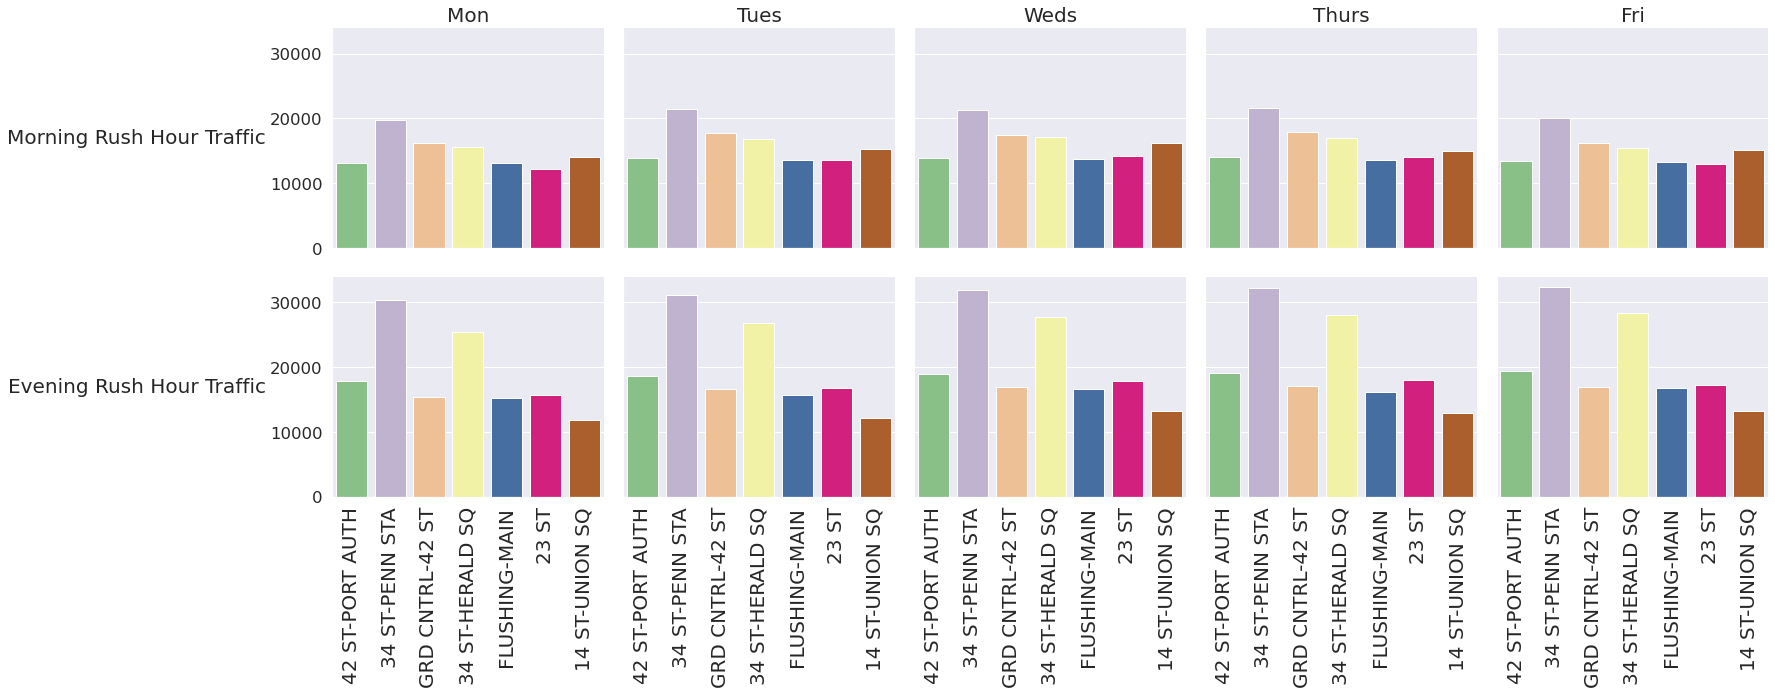

In [122]:
# Filtering the Time chunked dataframe from above to the selected 7  Manhattan stations

seven_stations_time_df = pd.DataFrame(time_df[time_df.STATION.isin(manhattan_stations)])
seven_stations_time_df.drop_duplicates(inplace=True)

sns.set(font_scale=1.5)
d_compare = sns.catplot(
    x='STATION', 
    y='mean_daily_traf', 
    col='day_of_week', 
    row='timeblock', 
    data=seven_stations_time_df,
    kind='bar',
    palette='Accent')

d_compare.set_xticklabels(fontsize=20, rotation=90)
d_compare.set_axis_labels("")
d_compare.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
d_compare.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')

for i, j  in wkday_dict.items():
    try:
        d_compare.axes[0,int(i)].set_title(j, fontsize=20)
        d_compare.axes[1,int(i)].set_title('')
    except:
        pass
plt.tight_layout()

Shows a detailed comparison but hard to ascertain conclusions from the graph during a presentation.

Text(0, 0.5, '')

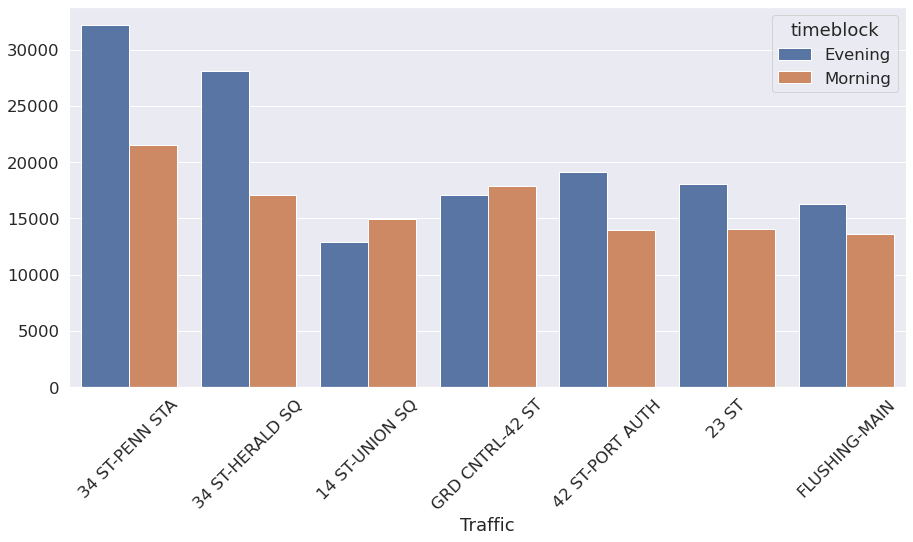

In [123]:
# Plotting just a single day graph to visualize difference between morning & evening commuter traffic

thursday_traffic_df = seven_stations_time_df[seven_stations_time_df.day_of_week==3].drop(columns='turn_traffic')

plt.figure(figsize=[15,7])

sns.barplot(x='STATION', y='mean_daily_traf', hue='timeblock', data=thursday_traffic_df,
             order=manhattan_stations, hue_order=['Evening', 'Morning'])

plt.xticks(rotation=45)
plt.xlabel('Traffic')
plt.ylabel('')

### Final recommendation would be to focus on 34th - Penn Station on Thursday evening, if WTWY is highly constrained on street team capacity.